# LSTM model for multivariate time series

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
import os
# Disable INFO & WARNINGS 
# due to bug with dynamic library libcudart.so.11.0 & others
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot

# prepare data for lstm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2022-10-18 16:35:12.509339: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Improvements to explore:**  
* One-hot encoding of wind direction  
https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
* Making all series stationary with differencing and seasonal adjustment.
* Providing more than 1 hour of input time steps.

In [17]:
## Load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.shape)
print(dataset.head())
print(dataset.tail(3))

(43800, 8)
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70     0     0
2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72     0     0
2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85     0     0


* We wanto to forecast **pollution** at the next hour (1 time step)
* Wind direction (wnd_dir) is categorical
* 5 year data/hour

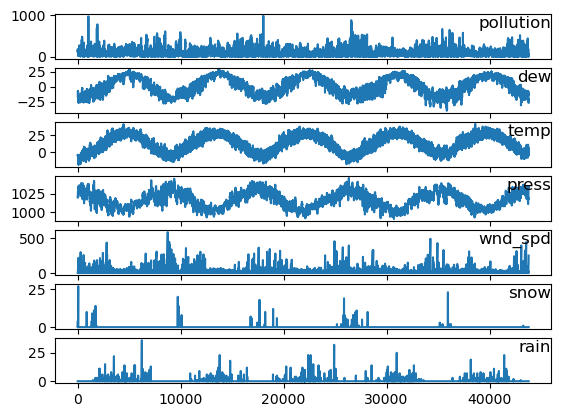

In [3]:
## Plot the data
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7] # wind_dir not ploted (categorical)
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

## Multivariate LSTM forecast

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

**MinMaxScaler.** Often used as an alternative to zero mean, unit variance scaling.
$$
X_{std} = \frac{X - X_{min}}{X_{max} - X_{min}} \\
X_{scaled} = X_{std} * (max - min) + min
$$
where min, max = `feature_range`.  
  


In [5]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) #'SE' --> 4, 'NW' --> 1, ...
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)       
pd.DataFrame(scaled)

,0,1,2,3,4,5,6,7
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
...,...,...,...,...,...,...,...,...
43795,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [6]:
# frame as supervised learning
# t-1 (lagged) df, framed to predict the current time (t)
reframed = series_to_supervised(scaled, 1, 1)   # a Pandas DF

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
pd.DataFrame(reframed)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


### Define and fit model

1. Split train & test
2. Define the LSTM model (50 neurons, 1 neuron, 1 time step, 8 features)

In [7]:
# Split of data into train-test, input-output 
# & reshape data for the LSTM format [samples, timesteps, features]

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print('After split:')
print('train_X:', train_X.shape, ', train_y:', train_y.shape)
print('test_X:', test_X.shape, ', test_y:',test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print('After reshape:')
print('train_X:', train_X.shape, ', train_y:', train_y.shape)
print('test_X:', test_X.shape, ', test_y:',test_y.shape)

After split:
train_X: (8760, 8) , train_y: (8760,)
test_X: (35039, 8) , test_y: (35039,)
After reshape:
train_X: (8760, 1, 8) , train_y: (8760,)
test_X: (35039, 1, 8) , test_y: (35039,)


Epoch 1/15
122/122 - 6s - loss: 0.0571 - val_loss: 0.0628 - 6s/epoch - 45ms/step
Epoch 2/15
122/122 - 2s - loss: 0.0388 - val_loss: 0.0651 - 2s/epoch - 16ms/step
Epoch 3/15
122/122 - 2s - loss: 0.0233 - val_loss: 0.0521 - 2s/epoch - 15ms/step
Epoch 4/15
122/122 - 2s - loss: 0.0174 - val_loss: 0.0398 - 2s/epoch - 15ms/step
Epoch 5/15
122/122 - 2s - loss: 0.0157 - val_loss: 0.0267 - 2s/epoch - 16ms/step
Epoch 6/15
122/122 - 2s - loss: 0.0152 - val_loss: 0.0191 - 2s/epoch - 16ms/step
Epoch 7/15
122/122 - 2s - loss: 0.0150 - val_loss: 0.0182 - 2s/epoch - 16ms/step
Epoch 8/15
122/122 - 2s - loss: 0.0149 - val_loss: 0.0176 - 2s/epoch - 16ms/step
Epoch 9/15
122/122 - 2s - loss: 0.0149 - val_loss: 0.0162 - 2s/epoch - 15ms/step
Epoch 10/15
122/122 - 2s - loss: 0.0147 - val_loss: 0.0154 - 2s/epoch - 15ms/step
Epoch 11/15
122/122 - 2s - loss: 0.0147 - val_loss: 0.0148 - 2s/epoch - 16ms/step
Epoch 12/15
122/122 - 2s - loss: 0.0147 - val_loss: 0.0145 - 2s/epoch - 15ms/step
Epoch 13/15
122/122 - 2s 

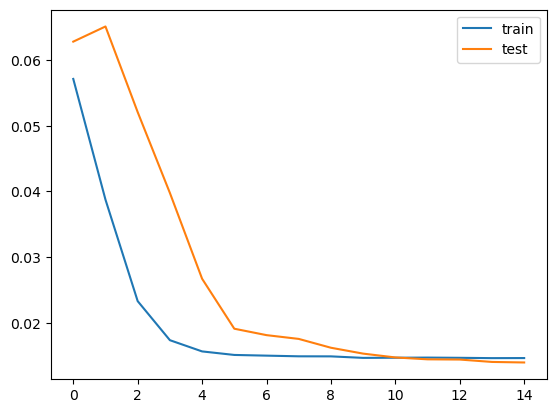

In [8]:
# LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=15, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluate the model

We combine the forecast with the test dataset and invert the scaling

In [9]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1095/1095 [==============================] - 3s 2ms/step
Test RMSE: 26.977


## Train On Multiple -3 hours- Lag Timesteps 

The changes needed to train on multiple time steps are:

* Frame the problem suitably when calling `series_to_supervised()`
* We no longer drop the columns of all fields @ ob(t)
* The way we evaluate the model. How we reconstruct the rows with 8 columns 
suitable for reversing the scaling operation to get $y$ or $\hat{y}$ to the original scale.  


Fitting the model stays the same


In [10]:
# 3 hours lag problem. 

# Specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.008048,0.250000,0.311475,0.745455,0.333333,0.365103,0.000000,0.0,0.009054,0.264706,...,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.009054,0.264706,0.295082,0.763638,0.333333,0.377322,0.000000,0.0,0.010060,0.264706,...,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,...,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,...,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


scaled.shape: (n, 8)  
reframed.shape: (n, 32)  $\longrightarrow (3 * 8) + 8$ columns  

We take $(3*8)$ columns as input across the previous `n_hours`.  
We take just the pollution variable as output at the following hour as follows:  

In [11]:
# split into train and test sets
# The same  operation as before
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [12]:
# split into input and outputs
# Changed operation
n_obs = n_hours * n_features  # 3 * 8 = 24 n_obs
X = reframed.iloc[:,:n_obs]
Y = reframed.iloc[:,[-n_features]]
# Info: which columns will be taken as X and Y
print('x columns:')
print(X.columns)
print('y columns')
print(Y.columns)

x columns:
Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)',
       'var8(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)',
       'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)'],
      dtype='object')
y columns
Index(['var1(t)'], dtype='object')


In [13]:
# split the columns
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print('After split:')
print('train_X:', train_X.shape, ', train_y:', train_y.shape)
print('test_X:', test_X.shape, ', test_y:',test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
# The same  operation as before
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print('After reshape:')
print('train_X:', train_X.shape, ', train_y:', train_y.shape)
print('test_X:', test_X.shape, ', test_y:',test_y.shape)

After split:
train_X: (8760, 24) , train_y: (8760,)
test_X: (35037, 24) , test_y: (35037,)
After reshape:
train_X: (8760, 3, 8) , train_y: (8760,)
test_X: (35037, 3, 8) , test_y: (35037,)


Epoch 1/15
122/122 - 3s - loss: 0.0531 - val_loss: 0.0411 - 3s/epoch - 27ms/step
Epoch 2/15
122/122 - 2s - loss: 0.0254 - val_loss: 0.0312 - 2s/epoch - 17ms/step
Epoch 3/15
122/122 - 2s - loss: 0.0208 - val_loss: 0.0234 - 2s/epoch - 17ms/step
Epoch 4/15
122/122 - 2s - loss: 0.0206 - val_loss: 0.0207 - 2s/epoch - 18ms/step
Epoch 5/15
122/122 - 2s - loss: 0.0202 - val_loss: 0.0205 - 2s/epoch - 20ms/step
Epoch 6/15
122/122 - 3s - loss: 0.0197 - val_loss: 0.0189 - 3s/epoch - 21ms/step
Epoch 7/15
122/122 - 3s - loss: 0.0193 - val_loss: 0.0190 - 3s/epoch - 26ms/step
Epoch 8/15
122/122 - 3s - loss: 0.0190 - val_loss: 0.0184 - 3s/epoch - 21ms/step
Epoch 9/15
122/122 - 2s - loss: 0.0188 - val_loss: 0.0179 - 2s/epoch - 18ms/step
Epoch 10/15
122/122 - 2s - loss: 0.0181 - val_loss: 0.0176 - 2s/epoch - 19ms/step
Epoch 11/15
122/122 - 3s - loss: 0.0179 - val_loss: 0.0172 - 3s/epoch - 21ms/step
Epoch 12/15
122/122 - 3s - loss: 0.0173 - val_loss: 0.0167 - 3s/epoch - 21ms/step
Epoch 13/15
122/122 - 2s 

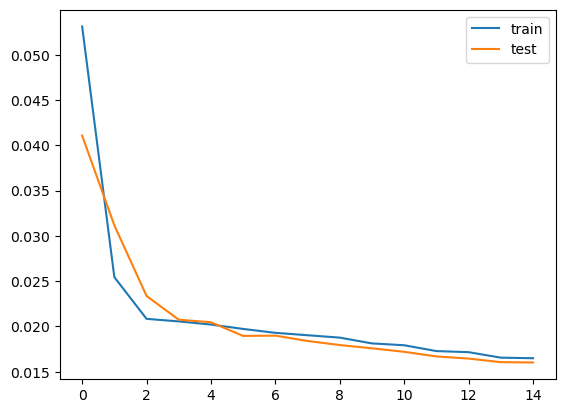

In [14]:
# Fitting the model stays the same. I only added more epochs
# LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=15, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features)) # 2D [n, 3 * 8 ]

1095/1095 [==============================] - 3s 2ms/step


The last change: The reconstruction of the $y$ and $\hat{y}$

In [16]:
# invert scaling for forecast
    # test_X.shape --> n, 24
    # test_X[:, -7:].shape --> n, last 7 cols
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
print('inv_yhat after concatenation:', inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

inv_yhat after concatenation: (35037, 8)
Test RMSE: 27.884
